# Load Audio Files

In [ ]:
import os

scream_dir = r"D:\Ashraf\NCI\Semester 2\Research In Computing\Dataset\Screaming"
non_scream_dir = r"D:\Ashraf\NCI\Semester 2\Research In Computing\Dataset\NotScreaming"

file_paths = []
labels = []

# Load scream files with label 'yes'
for file_name in os.listdir(scream_dir):
    file_paths.append(os.path.join(scream_dir, file_name))
    labels.append("yes")

# Load non-scream files with label 'no'
for file_name in os.listdir(non_scream_dir):
    file_paths.append(os.path.join(non_scream_dir, file_name))
    labels.append("no")

print(f"Loaded {len(file_paths)} audio files.")
print(f"Scream files labeled 'yes': {labels.count('yes')}")
print(f"Non-scream files labeled 'no': {labels.count('no')}")

Loaded 3493 audio files.
Scream files labeled 'yes': 862
Non-scream files labeled 'no': 2631


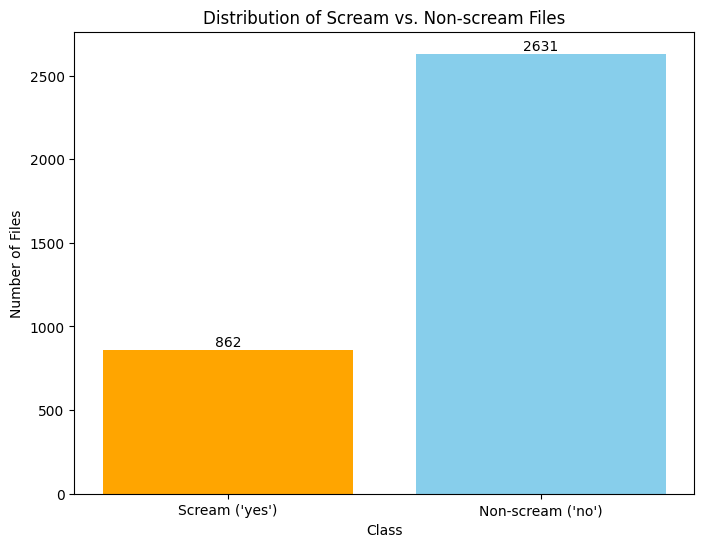

In [ ]:
# Visualize label distribution

import matplotlib.pyplot as plt

label_counts = [labels.count("yes"), labels.count("no")]
label_names = ["Scream ('yes')", "Non-scream ('no')"]

plt.figure(figsize=(8, 6))
bars = plt.bar(label_names, label_counts, color=['orange', 'skyblue'])
plt.xlabel("Class")
plt.ylabel("Number of Files")
plt.title("Distribution of Scream vs. Non-scream Files")

plt.bar_label(bars, label_type='edge')

plt.show()

# Check Sample Rate of the audio files

In [ ]:
import librosa
from collections import Counter

sample_rates = []

def get_sample_rate(file_path):
    return librosa.get_samplerate(file_path)

for file_path in file_paths:
    sample_rate = get_sample_rate(file_path)
    sample_rates.append(sample_rate)

sample_rate_counts = Counter(sample_rates)

print("Sample Rate Overview:")
for rate, count in sample_rate_counts.items():
    print(f"Sample Rate: {rate} Hz")
    print(f"Number of Files: {count}")


Sample Rate Overview:
Sample Rate: 44100 Hz
Number of Files: 3493


# Visualize Waveforms of raw audio files

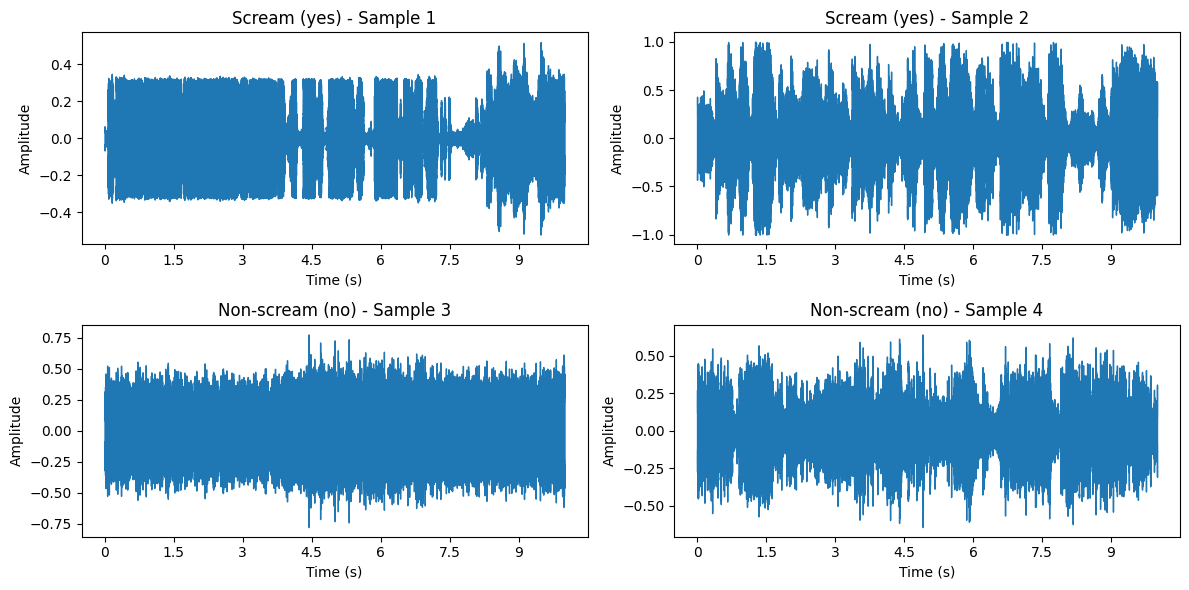

In [ ]:
import random
import librosa.display
import matplotlib.pyplot as plt

def display_waveforms(file_paths, labels, num_samples=2):
    scream_files = [file for file, label in zip(file_paths, labels) if label == "yes"]
    non_scream_files = [file for file, label in zip(file_paths, labels) if label == "no"]

    scream_samples = random.sample(scream_files, num_samples)
    non_scream_samples = random.sample(non_scream_files, num_samples)

    plt.figure(figsize=(12, 6))
    for i, file_path in enumerate(scream_samples + non_scream_samples, 1):
        audio, sample_rate = librosa.load(file_path, sr=44100)
        plt.subplot(2, num_samples, i)
        librosa.display.waveshow(audio, sr=sample_rate)
        title = "Scream (yes)" if i <= num_samples else "Non-scream (no)"
        plt.title(f"{title} - Sample {i}")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

# Display waveforms
display_waveforms(file_paths, labels, num_samples=2)


# Visualize Spectogram using Short-Time Fourier Transform (STFT)

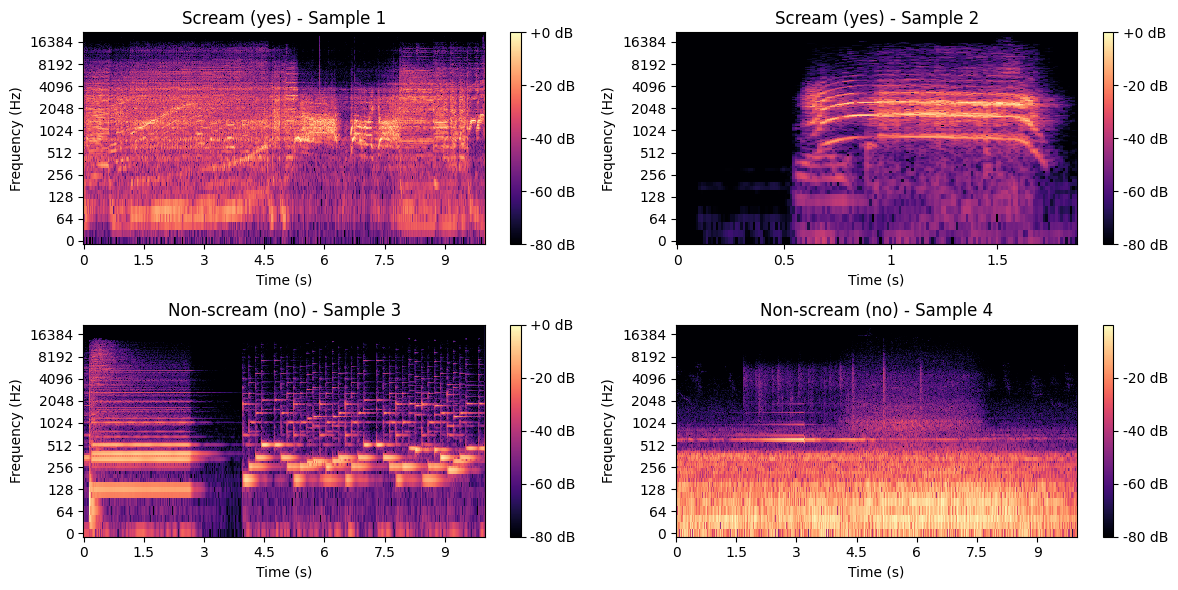

In [ ]:
import librosa.display
import numpy as np

def display_stft_spectrograms(file_paths, labels, num_samples=2):
    scream_files = [file for file, label in zip(file_paths, labels) if label == "yes"]
    non_scream_files = [file for file, label in zip(file_paths, labels) if label == "no"]

    scream_samples = random.sample(scream_files, num_samples)
    non_scream_samples = random.sample(non_scream_files, num_samples)

    plt.figure(figsize=(12, 6))
    for i, file_path in enumerate(scream_samples + non_scream_samples, 1):
        audio, sample_rate = librosa.load(file_path, sr=44100)

        S = librosa.stft(audio)
        S_dB = librosa.amplitude_to_db(abs(S), ref=np.max)

        plt.subplot(2, num_samples, i)
        librosa.display.specshow(S_dB, sr=sample_rate, x_axis='time', y_axis='log')
        title = "Scream (yes)" if i <= num_samples else "Non-scream (no)"
        plt.title(f"{title} - Sample {i}")
        plt.colorbar(format='%+2.0f dB')
        plt.xlabel("Time (s)")
        plt.ylabel("Frequency (Hz)")

    plt.tight_layout()
    plt.show()

display_stft_spectrograms(file_paths, labels, num_samples=2)


# Data Augmentation for Scream Data

In [ ]:
def time_shift(audio, shift_max=0.2):
    shift = int(np.random.uniform(-shift_max, shift_max) * len(audio))
    return np.roll(audio, shift)

def pitch_shift(audio, sample_rate, n_steps):
    return librosa.effects.pitch_shift(audio, sr=sample_rate, n_steps=n_steps)

def speed_change(audio, speed_factor):
    return librosa.effects.time_stretch(audio, rate=speed_factor)

def add_noise(audio, noise_factor=0.005):
    noise = np.random.randn(len(audio))
    return audio + noise_factor * noise

def augment_scream_data(audio, sample_rate):
    augmented_audios = [
        time_shift(audio),
        pitch_shift(audio, sample_rate, n_steps=np.random.randint(-2, 3)),
        speed_change(audio, speed_factor=np.random.uniform(0.9, 1.1)),
        add_noise(audio)
    ]
    return augmented_audios

scream_augmented_data = []
for file_path, label in zip(file_paths, labels):
    if label == "yes":
        audio, sample_rate = librosa.load(file_path, sr=44100)
        augmented_versions = augment_scream_data(audio, sample_rate)
        scream_augmented_data.extend(augmented_versions)


# Extract MFCC from original and augmented data

In [ ]:
import numpy as np
import pandas as pd

def extract_mfcc(audio, sample_rate, n_mfcc=40):
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    return np.mean(mfccs.T, axis=0)

features = []
feature_labels = []

for file_path, label in zip(file_paths, labels):
    audio, sample_rate = librosa.load(file_path, sr=44100)
    mfccs = extract_mfcc(audio, sample_rate)
    features.append(mfccs)
    feature_labels.append(label)

for file_path, label in zip(file_paths, labels):
    if label == "yes":
        audio, sample_rate = librosa.load(file_path, sr=44100)
        augmented_versions = augment_scream_data(audio, sample_rate)
        for augmented_audio in augmented_versions:
            mfccs = extract_mfcc(augmented_audio, sample_rate)
            features.append(mfccs)
            feature_labels.append("yes")

data_df = pd.DataFrame(features)
data_df['label'] = feature_labels

data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,label
0,-128.820404,153.944534,-44.551453,46.304588,-14.284417,31.651188,-14.675584,19.770298,-7.879022,9.396490,...,0.262857,-5.313453,-1.081506,-5.391929,-0.926695,-2.571667,-1.125707,-0.436007,-2.030136,yes
1,-202.978134,187.059952,-42.500618,13.506268,-12.304253,-7.316109,-1.330590,-21.910936,-7.235997,-6.177976,...,-5.574987,-0.810677,-2.091826,1.143084,3.322026,1.347301,3.914363,2.556849,2.090144,yes
2,-226.987167,101.099083,-146.919601,-21.155012,-5.827855,-34.957806,-20.850714,-4.434820,-21.994427,-14.063478,...,-1.437095,1.146698,-9.001393,-8.177377,2.904241,4.614923,-3.778498,-8.888506,4.506899,yes
3,-136.594025,125.529327,-76.607018,15.533764,-20.286385,6.486753,1.700458,-7.119390,-15.118313,0.129713,...,-3.643356,-0.518553,3.861395,1.867178,-4.824398,-5.871456,0.156493,2.962239,1.945034,yes
4,-362.343384,189.253845,-66.412292,-54.127754,26.699265,-10.607894,-25.457176,19.010557,4.458371,-28.553083,...,-1.394129,-2.366649,-1.712699,-0.899607,4.714460,11.561172,8.471269,0.494892,-1.607653,yes


In [19]:
data_df.shape

(6941, 41)

In [ ]:
# data_df.to_csv('MFCC_Extracted_Data.csv', index=False)

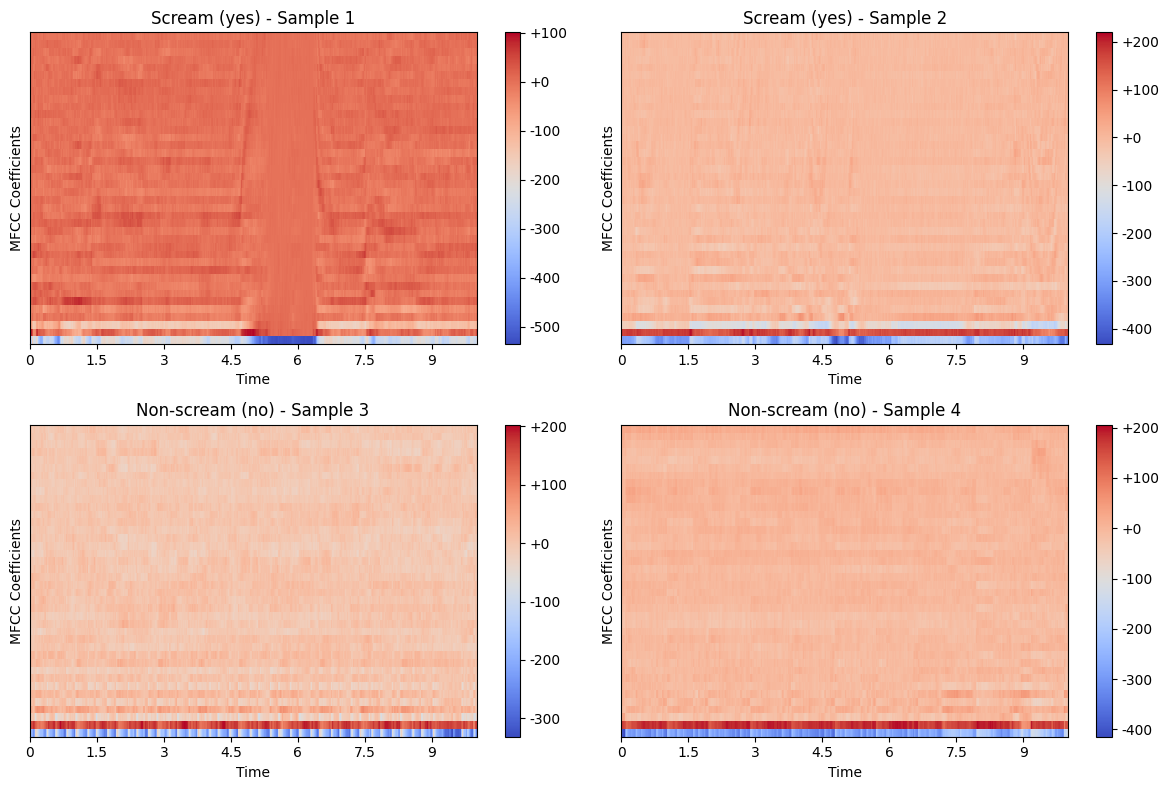

In [ ]:
# Visualize MFCCs

def display_mfcc(file_paths, labels, num_samples=2, n_mfcc=40):
    scream_files = [file for file, label in zip(file_paths, labels) if label == "yes"]
    non_scream_files = [file for file, label in zip(file_paths, labels) if label == "no"]

    scream_samples = random.sample(scream_files, num_samples)
    non_scream_samples = random.sample(non_scream_files, num_samples)

    plt.figure(figsize=(12, 8))
    for i, file_path in enumerate(scream_samples + non_scream_samples, 1):
        audio, sample_rate = librosa.load(file_path, sr=44100)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)

        plt.subplot(2, num_samples, i)
        librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time')
        plt.colorbar(format='%+2.0f')
        title = "Scream (yes)" if i <= num_samples else "Non-scream (no)"
        plt.title(f"{title} - Sample {i}")
        plt.xlabel("Time")
        plt.ylabel("MFCC Coefficients")
        
    plt.tight_layout()
    plt.show()

display_mfcc(file_paths, labels, num_samples=2, n_mfcc=40)

# Modelling

# Splitting the data

In [ ]:
from sklearn.model_selection import train_test_split

X = data_df.drop(columns=['label'])
y = data_df['label'] 

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42, stratify=y_train_val)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")


Training set size: 4857
Validation set size: 1042
Test set size: 1042


# Standardization

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# SVM

In [ ]:
from sklearn.svm import SVC

model = SVC(kernel='linear', random_state=42)

model.fit(X_train_scaled, y_train)


SVC(kernel='linear', random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_val_pred = model.predict(X_val_scaled)

val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.2f}")

print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred))

print("\nValidation Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))


Validation Accuracy: 0.80

Validation Classification Report:
              precision    recall  f1-score   support

          no       0.74      0.73      0.74       395
         yes       0.84      0.85      0.84       647

    accuracy                           0.80      1042
   macro avg       0.79      0.79      0.79      1042
weighted avg       0.80      0.80      0.80      1042


Validation Confusion Matrix:
[[288 107]
 [ 99 548]]


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf']}

grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Validation Score:", grid_search.best_score_)


Best Parameters: {'C': 10, 'kernel': 'rbf'}
Best Validation Score: 0.8651377604861986


In [ ]:
final_model = grid_search.best_estimator_ if 'grid_search' in locals() else model

y_test_pred = final_model.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")

print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))


Test Accuracy: 0.88

Test Classification Report:
              precision    recall  f1-score   support

          no       0.87      0.80      0.83       395
         yes       0.88      0.93      0.91       647

    accuracy                           0.88      1042
   macro avg       0.88      0.86      0.87      1042
weighted avg       0.88      0.88      0.88      1042


Test Confusion Matrix:
[[315  80]
 [ 46 601]]


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix

y_test_pred = final_model.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")

precision = precision_score(y_test, y_test_pred, average=None)
recall = recall_score(y_test, y_test_pred, average=None)
f1 = f1_score(y_test, y_test_pred, average=None)

print("\nPrecision for each class:", precision)
print("Recall for each class:", recall)
print("F1-score for each class:", f1)

print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))


Test Accuracy: 0.88

Precision for each class: [0.87257618 0.8825257 ]
Recall for each class: [0.79746835 0.92890263]
F1-score for each class: [0.83333333 0.90512048]

Test Classification Report:
              precision    recall  f1-score   support

          no       0.87      0.80      0.83       395
         yes       0.88      0.93      0.91       647

    accuracy                           0.88      1042
   macro avg       0.88      0.86      0.87      1042
weighted avg       0.88      0.88      0.88      1042


Test Confusion Matrix:
[[315  80]
 [ 46 601]]


# Combine SVM and KNN

In [ ]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

svm_model = SVC(C=10, kernel='rbf', probability=True, random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=10)

# Create a VotingClassifier with SVM and KNN
ensemble_model = VotingClassifier(estimators=[
    ('svm', svm_model),
    ('knn', knn_model)
], voting='soft')

ensemble_model.fit(X_train_scaled, y_train)

y_test_pred = ensemble_model.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Ensemble Test Accuracy: {test_accuracy:.2f}")

print("\nEnsemble Test Classification Report:")
print(classification_report(y_test, y_test_pred))

print("\nEnsemble Test Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))


Ensemble Test Accuracy: 0.88

Ensemble Test Classification Report:
              precision    recall  f1-score   support

          no       0.88      0.78      0.83       395
         yes       0.88      0.93      0.90       647

    accuracy                           0.88      1042
   macro avg       0.88      0.86      0.87      1042
weighted avg       0.88      0.88      0.87      1042


Ensemble Test Confusion Matrix:
[[310  85]
 [ 44 603]]


# Multilayer Perceptron Model (MLP)

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

mlp_model = MLPClassifier(
    hidden_layer_sizes=(100, 100),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    max_iter=300,
    random_state=42
)

mlp_model.fit(X_train_scaled, y_train)

y_test_pred = mlp_model.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"MLP Test Accuracy: {test_accuracy:.2f}")

print("\nMLP Test Classification Report:")
print(classification_report(y_test, y_test_pred))

print("\nMLP Test Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))


MLP Test Accuracy: 0.87

MLP Test Classification Report:
              precision    recall  f1-score   support

          no       0.89      0.76      0.82       395
         yes       0.87      0.94      0.90       647

    accuracy                           0.87      1042
   macro avg       0.88      0.85      0.86      1042
weighted avg       0.88      0.87      0.87      1042


MLP Test Confusion Matrix:
[[300  95]
 [ 36 611]]


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

param_grid = {
    'hidden_layer_sizes': [(100,), (100, 50), (150, 100), (100, 100, 50)],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [300, 500]
}

mlp_model = MLPClassifier(random_state=42)

grid_search = GridSearchCV(mlp_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Validation Accuracy:", grid_search.best_score_)


Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Parameters: {'alpha': 0.1, 'hidden_layer_sizes': (100, 100, 50), 'learning_rate': 'constant', 'max_iter': 300}
Best Validation Accuracy: 0.8727642793268151


# RESNET34

# Convert MFCC to images

In [46]:
# Define a directory to save MFCC images
image_dir = r"D:\Ashraf\NCI\Semester 2\Research In Computing\Code\New\MFCC_Images"
os.makedirs(image_dir, exist_ok=True)

def save_mfcc_image(file_path, label, image_dir):
    audio, sample_rate = librosa.load(file_path, sr=44100)
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    
    # Create a subdirectory for each class if it doesn't exist
    class_dir = os.path.join(image_dir, label)
    os.makedirs(class_dir, exist_ok=True)
    
    # Save the MFCC as an image in the class directory
    plt.figure(figsize=(3, 3))
    librosa.display.specshow(mfcc, sr=sample_rate, x_axis='time')
    plt.axis('off')
    filename = os.path.basename(file_path).replace('.wav', '.png')
    plt.savefig(os.path.join(class_dir, filename), bbox_inches='tight', pad_inches=0)
    plt.close()

# Apply to all files
for file_path, label in zip(file_paths, labels):
    save_mfcc_image(file_path, label, image_dir)


In [48]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=image_dir, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [49]:
import torch
import torch.nn as nn
from torchvision import models

resnet34 = models.resnet34(pretrained=True)

num_features = resnet34.fc.in_features
resnet34.fc = nn.Linear(num_features, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet34 = resnet34.to(device)


c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\Lenovo/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:04<00:00, 21.4MB/s]


In [50]:
import torch.optim as optim

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet34.parameters(), lr=0.001)


In [51]:
num_epochs = 10

for epoch in range(num_epochs):
    resnet34.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = resnet34(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")


Epoch 1/10, Loss: 0.5258
Epoch 2/10, Loss: 0.3776
Epoch 3/10, Loss: 0.3421
Epoch 4/10, Loss: 0.3331
Epoch 5/10, Loss: 0.3087
Epoch 6/10, Loss: 0.2990
Epoch 7/10, Loss: 0.2613
Epoch 8/10, Loss: 0.2478
Epoch 9/10, Loss: 0.2411
Epoch 10/10, Loss: 0.2076


In [52]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

resnet34.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet34(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(all_labels, all_preds)
print(f"ResNet-34 Test Accuracy: {test_accuracy:.2f}")
print("\nResNet-34 Classification Report:")
print(classification_report(all_labels, all_preds))
print("\nResNet-34 Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


ResNet-34 Test Accuracy: 0.86

ResNet-34 Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.98      0.92       540
           1       0.88      0.47      0.61       159

    accuracy                           0.86       699
   macro avg       0.87      0.72      0.76       699
weighted avg       0.87      0.86      0.85       699


ResNet-34 Confusion Matrix:
[[530  10]
 [ 85  74]]
